In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc
import pdb

In [25]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [2]:
from sklearn.covariance import ledoit_wolf
from sklearn.manifold import TSNE

In [17]:
cd /hdd/qudgks/

/hdd/qudgks


In [21]:
cd 3-10-52/

/hdd/qudgks/2022-4-15/3-10-52


In [22]:
before = {}
after = {}
after["train_emb_a"] = np.load("train_emb.txta.npy")
after["in_emb_a"] = np.load("in_emb.txta.npy")
after["out_emb_a"] = np.load("ood_emb.txta.npy")
labels = np.load("y_label.txta.npy")

Using ledoit-wolf covariance estimator.
0.9321297777777777


<AxesSubplot:title={'center':'Score Distribution'}, xlabel='score', ylabel='Count'>

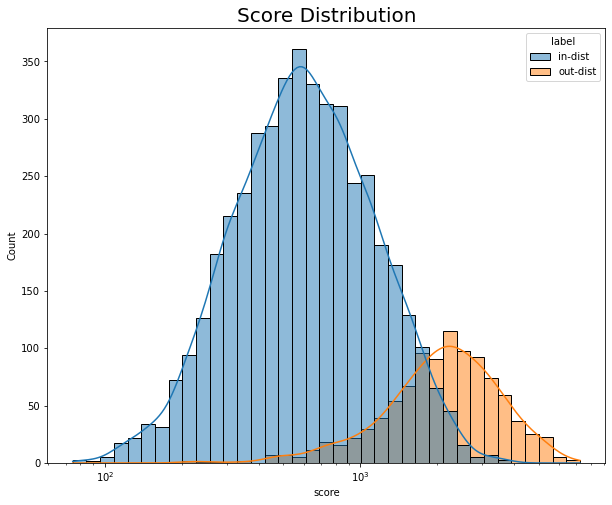

In [26]:
din, dood, dtrain, test_in_pred, test_out_pred = get_scores_multi_cluster(after["train_emb_a"],after["in_emb_a"],after["out_emb_a"],labels, None,'lw')
score_one = np.append(din,dood)
n = [0 for i in range(len(din))]
N = [1 for i in range(len(dood))]
#n.extend(num)
n.extend(N)
fpr, tpr, thresholds=roc_curve(n, -score_one, pos_label=0)                       
auroc_one = auc(fpr,tpr)

print(auroc_one)

plt.figure(figsize=(10, 8))
plt.title("Score Distribution",fontsize=20)
n = ["in-dist" for i in range(len(din))]
N = ["out-dist" for i in range(len(dood))]
#n.extend(num)
n.extend(N)
data = {'score': score_one, "label": n}
sns.histplot(data = data, x= "score", hue= 'label',kde=True,log_scale=True)


In [28]:
len(test_in_pred)

4500

In [34]:
test_in_pred

array([3449.06391988, 3464.41925939, 3464.89136293, ..., 3466.83475871,
       3472.96103673, 3458.6921405 ])

0.7606246666666666


<AxesSubplot:title={'center':'Score Distribution'}, xlabel='score', ylabel='Count'>

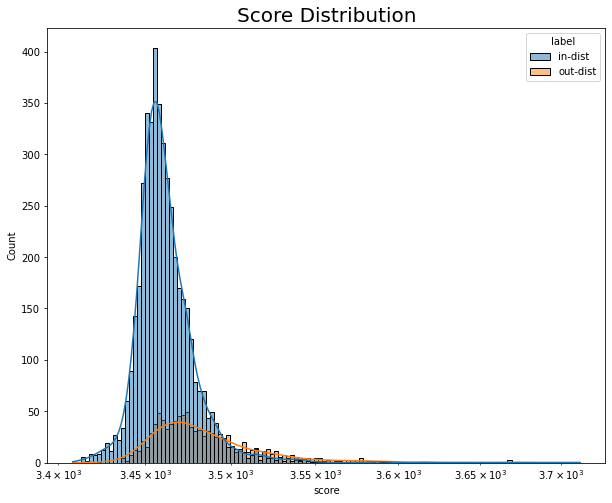

In [32]:
score_one = np.append(test_in_pred, test_out_pred)

n = [0 for i in range(len(din))]
N = [1 for i in range(len(dood))]
n.extend(N)
fpr, tpr, thresholds=roc_curve(n, -score_one, pos_label=0)                       
auroc_one = auc(fpr,tpr)

print(auroc_one)

plt.figure(figsize=(10, 8))
plt.title("Score Distribution",fontsize=20)
n = ["in-dist" for i in range(len(din))]
N = ["out-dist" for i in range(len(dood))]
#n.extend(num)
n.extend(N)
data = {'score': score_one, "label": n}
sns.histplot(data = data, x= "score", hue= 'label',kde=True,log_scale=True)

In [7]:
def get_scores_multi_cluster(ftrain, ftest, food, ypred,toy = None, shrunkcov=True):
    xc = [ftrain[ypred == i] for i in np.unique(ypred)]
    if shrunkcov =="lw":
        print("Using ledoit-wolf covariance estimator.")
        cov = np.linalg.pinv(ledoit_wolf(ftrain)[0])
    elif shrunkcov == "emp":
        from sklearn.covariance import EmpiricalCovariance
        cov =  np.linalg.pinv(EmpiricalCovariance().fit(ftrain).covariance_)
    elif shrunkcov == "sh":
        print("sh")
        cov = lambda x:  ShrunkCovariance(shrinkage=0.1).fit(x).covariance_
    elif shrunkcov == "osa":
        print("osa")
        cov = lambda x: OAS().fit(x).covariance_
    else:
        print("nor")
        cov = np.linalg.pinv(np.cov(ftrain.T, bias=True))

    toys = None
    
    if isinstance(toy,np.ndarray):

        toys = [
        np.sum(
            (toy - np.mean(x, axis=0, keepdims=True))
            * (
                cov.dot(
                    (toy - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]

    dtrain = [
        np.sum(
            (ftrain - np.mean(x, axis=0, keepdims=True))
            * (
                cov.dot(
                    (ftrain - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]       
    
    din = [
        np.sum(
            (ftest - np.mean(x, axis=0, keepdims=True))
            * (
                cov.dot(
                    (ftest - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]
    dood = [
        np.sum(
            (food - np.mean(x, axis=0, keepdims=True))
            * (
                cov.dot(
                    (food - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]
    din_f = din
    dood_f = dood
    dtrain_f = dtrain
    
    
    test_in_pred, test_out_pred = OC_SVM(ftrain, ftest, food)
    
    din = np.min(din, axis=0)
    dood = np.min(dood, axis=0)
    dtrain = np.min(dtrain, axis=0)
    toys = np.min(toys, axis=0)
    return din, dood, dtrain, test_in_pred, test_out_pred

In [5]:
from sklearn.svm import OneClassSVM

In [6]:
def OC_SVM(ftrain, ftest, food):
    cls = OneClassSVM(gamma='auto')
    train_x = ftrain
    cls.fit(train_x)
    test_in_pred = cls.score_samples(ftest)
    test_out_pred = cls.score_samples(food)
    
    
    return test_in_pred, test_out_pred